In [46]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir(r"C:\Users\pavan\Desktop\sarcasm")

C:\Users\pavan\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
data = pd.read_csv("/Users/pavan/Desktop/sarcasm/data/sarcasm_data_train.csv")

In [12]:
del data['Unnamed: 0']

In [13]:
data

,headline,is_sarcastic,clean_headline
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...
1,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...
2,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...
3,"boehner just wants wife to listen, not come up...",1,"boehner wants wife listen, come alternative de..."
4,j.k. rowling wishes snape happy birthday in th...,0,j.k. rowling wishes snape happy birthday magic...
...,...,...,...
26704,american politics in moral free-fall,0,american politics moral free-fall
26705,america's best 20 hikes,0,america's best 20 hikes
26706,reparations and obama,0,reparations obama
26707,israeli ban targeting boycott supporters raise...,0,israeli ban targeting boycott supporters raise...


Converting text to token by gensim

In [22]:
words = []
for i in data.clean_headline.values:
    words.append(i.split())
words[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  "'black",
  "code'",
  'minority',
  'shoppers'],
 ["'roseanne'",
  'revival',
  'catches',
  'thorny',
  'political',
  'mood,',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  "son's",
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen,',
  'come',
  'alternative',
  'debt-reduction',
  'ideas'],
 ['j.k.', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way']]

initialising gensim

In [16]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 200

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 5 , min_count = 1)

In [17]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 100dim vector.

36436

In [24]:
from keras.preprocessing import text, sequence
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [25]:
x

array([[    0,     0,     0, ..., 15823,  2429, 10738],
       [    0,     0,     0, ..., 15824,   167,  1007],
       [    0,     0,     0, ...,  4365,   120, 15825],
       ...,
       [    0,     0,     0, ...,     0, 10737,    19],
       [    0,     0,     0, ...,  1481,  4195,  3831],
       [    0,     0,     0, ...,     0,  1588,   877]])

In [26]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [27]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [30]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)


C:\Users\pavan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


TRAINING WORD2VEC MODEL¶

In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           7287400   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 7,680,041
Trainable params: 7,680,041
Non-trainable params: 0
_________________________________________________________________


In [36]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, data.is_sarcastic , test_size = 0.3 , random_state = 0)

In [37]:
history = model.fit(x_train, y_train, batch_size = 128 , validation_data = (x_test,y_test) , epochs = 10)

Epoch 1/10
147/147 [==============================] - 210s 1s/step - loss: 0.5109 - acc: 0.7381 - val_loss: 0.4617 - val_acc: 0.7810
Epoch 2/10
147/147 [==============================] - 204s 1s/step - loss: 0.1465 - acc: 0.9462 - val_loss: 0.5128 - val_acc: 0.8014
Epoch 3/10
147/147 [==============================] - 204s 1s/step - loss: 0.0403 - acc: 0.9869 - val_loss: 0.8752 - val_acc: 0.7931
Epoch 4/10
147/147 [==============================] - 206s 1s/step - loss: 0.0128 - acc: 0.9958 - val_loss: 1.0179 - val_acc: 0.7876
Epoch 5/10
147/147 [==============================] - 204s 1s/step - loss: 0.0085 - acc: 0.9976 - val_loss: 1.1561 - val_acc: 0.7862
Epoch 6/10
147/147 [==============================] - 203s 1s/step - loss: 0.0048 - acc: 0.9988 - val_loss: 1.1624 - val_acc: 0.7883
Epoch 7/10
147/147 [==============================] - 203s 1s/step - loss: 0.0015 - acc: 0.9995 - val_loss: 1.4102 - val_acc: 0.7885
Epoch 8/10
147/147 [==============================] - 202s 1s/step - 

In [38]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

585/585 [==============================] - 43s 73ms/step - loss: 7.1435e-04 - acc: 0.9998
Accuracy of the model on Training Data is -  99.97860789299011
251/251 [==============================] - 22s 86ms/step - loss: 1.4390 - acc: 0.7861
Accuracy of the model on Testing Data is -  78.60975861549377


ANALYSIS AFTER TRAINING OF WORD2VEC MODEL

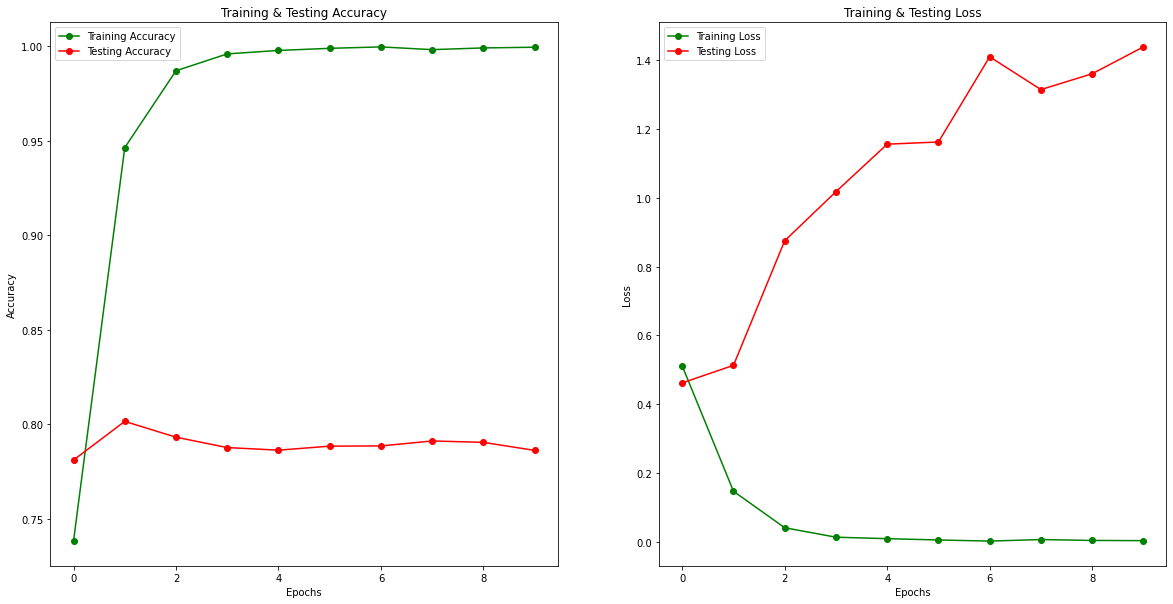

In [41]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [42]:
#SEEMS LIKE THE MODEL IS OVERFITTING AND NOT PERFORMING WELL ON THE TEST DATA
pred = model.predict_classes(x_test)
pred[:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [1],
       [1],
       [0],
       [1]])

In [44]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
cm = confusion_matrix(y_test,pred)
cm

array([[3529,  954],
       [ 760, 2770]], dtype=int64)

<AxesSubplot:>

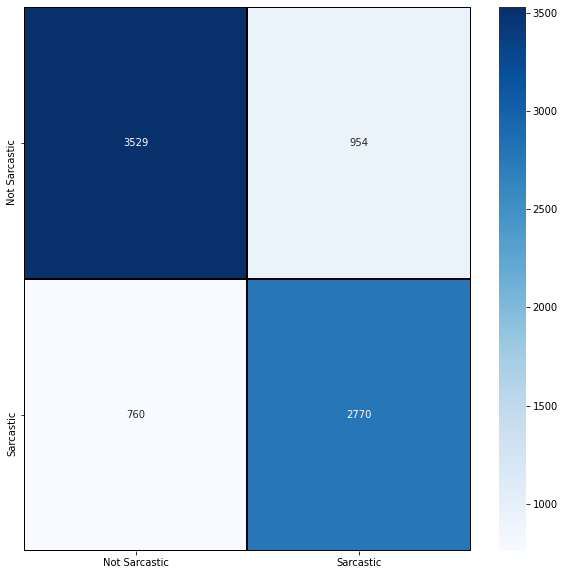

In [47]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [50]:
x_test

array([[    0,     0,     0, ...,    65,   365,  6569],
       [    0,     0,     0, ...,   190,   347,   181],
       [    0,     0,     0, ...,   226,   528,  1358],
       ...,
       [    0,     0,     0, ...,   104,  5105, 33509],
       [    0,     0,     0, ..., 34257,    61,   142],
       [    0,     0,     0, ...,  6956,  5598, 31796]])